In [3]:
from dotenv import load_dotenv

load_dotenv("../config/.env")

True

In [4]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///db/chinook/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [18]:
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """生成的 SQL 查询。"""
    query: Annotated[str, ..., "语法有效的 SQL 查询。"]

system_message = """
给定一个输入问题，创建一个语法正确的{dialect}查询来运行以帮助找到答案。除非用户在其问题中指定了他们希望获得的特定示例数量，否则始终将查询限制为最多{top_k}个结果。你可以按相关列对结果进行排序，以返回数据库中最有趣的示例。

切勿查询特定表中的所有列，只询问与问题相关的少数列。

注意只使用你在模式描述中能看到的列名。注意不要查询不存在的列。另外，注意哪些列在哪个表中。

仅使用以下表：
{table_info}
"""
user_prompt = "Qustion: {input}"
query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

def write_query(state: State):
    """生成用于获取信息的 SQL 查询。"""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

def execute_query(state: State):
    """执行 SQL 查询。"""
    excute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": excute_query_tool.invoke(state["query"])}

def generate_answer(state: State):
    """利用检索到的信息作为上下文来回答问题。"""
    prompt = (
        "鉴于以下用户问题、相应的 SQL 查询和 SQL 结果，请回答该用户问题。"
        f"问题: {state['question']}"
        f"SQL 查询: {state['query']}"
        f"SQL 查询结果: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence(
    [
        write_query,
        execute_query,
        generate_answer,
    ]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

/usr/local/Caskroom/miniconda/base/envs/analyst_chain/lib/python3.11/site-packages/pyppeteer/util.py:29: RuntimeWarning: coroutine '_render_mermaid_using_pyppeteer' was never awaited
  gc.collect()


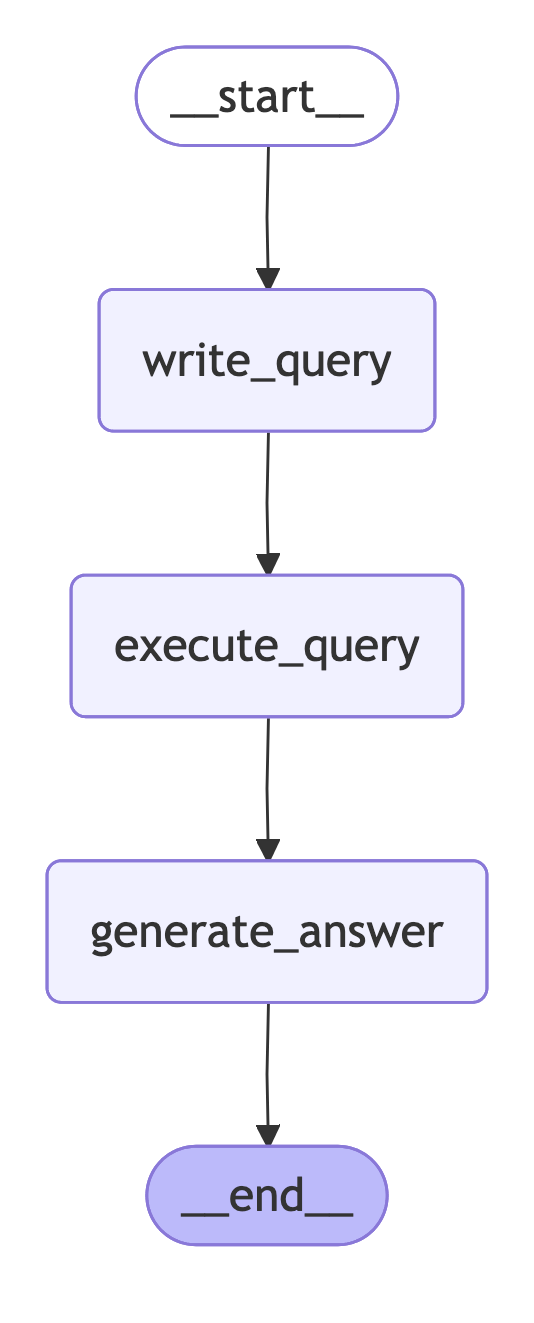

In [14]:
import nest_asyncio
from IPython.display import display, Image
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [19]:
for step in graph.stream(
    {"question": "有多少名员工？"},
    stream_mode="updates",
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '根据查询结果，公司总共有 8 名员工。'}}
